<a href="https://colab.research.google.com/github/Thenameisrakesh/Diwali_sales/blob/main/image_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
print("CUDA Available:", torch.cuda.is_available())


CUDA Available: True


In [6]:

!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q diffusers transformers accelerate safetensors
!pip install -q gradio
!pip install -q pillow


In [8]:
from huggingface_hub import login
login()


In [9]:
import torch

def get_device():
    if torch.cuda.is_available():
        print("✅ Using GPU")
        return torch.device("cuda"), torch.float16
    else:
        print("⚠ Using CPU (Slow)")
        return torch.device("cpu"), torch.float32

device, dtype = get_device()


✅ Using GPU


In [10]:
from diffusers import StableDiffusionPipeline

def load_model(model_id="runwayml/stable-diffusion-v1-5"):
    try:
        print("📦 Loading model...")

        pipe = StableDiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=dtype,
            safety_checker=None
        )

        pipe = pipe.to(device)

        if device.type == "cuda":
            pipe.enable_attention_slicing()

        print("✅ Model Loaded Successfully!")
        return pipe

    except Exception as e:
        raise RuntimeError(f"Model loading failed: {e}")

pipe = load_model()


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


📦 Loading model...


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its resul

✅ Model Loaded Successfully!


In [11]:
def generate_image(prompt, guidance_scale=9, steps=40):

    negative_prompt = (
        "blurry, low resolution, distorted, extra fingers, extra hands, "
        "multiple heads, bad anatomy, watermark, text, logo"
    )

    generator = torch.Generator(device=device).manual_seed(1234)

    try:
        if device.type == "cuda":
            with torch.autocast("cuda"):
                result = pipe(
                    prompt=prompt,
                    negative_prompt=negative_prompt,
                    guidance_scale=guidance_scale,
                    num_inference_steps=steps,
                    height=512,
                    width=512,
                    generator=generator
                )
        else:
            with torch.no_grad():
                result = pipe(
                    prompt=prompt,
                    negative_prompt=negative_prompt,
                    guidance_scale=guidance_scale,
                    num_inference_steps=steps,
                    height=512,
                    width=512,
                    generator=generator
                )

        return result.images[0]

    except torch.cuda.OutOfMemoryError:
        print("⚠ GPU Out of Memory. Reduce steps to 30.")


In [12]:
import os
from datetime import datetime

def save_image(image):
    output_dir = "outputs"

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{output_dir}/generated_{timestamp}.png"

    image.save(filename)
    print("💾 Saved at:", filename)

    return filename


Enter your prompt: stranger things poster
Enter inference steps (20-40 recommended): 40
Enter guidance scale (7-8 recommended): 8


  0%|          | 0/40 [00:00<?, ?it/s]

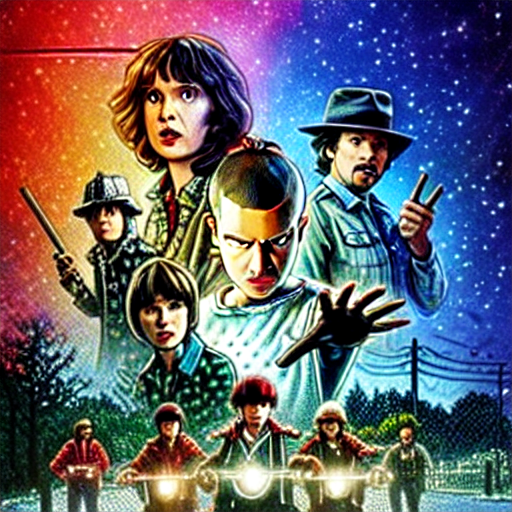

💾 Saved at: outputs/generated_20260220_161457.png


'outputs/generated_20260220_161457.png'

In [13]:
prompt = input("Enter your prompt: ")
steps = int(input("Enter inference steps (20-40 recommended): "))
guidance = float(input("Enter guidance scale (7-8 recommended): "))

image = generate_image(prompt, guidance, steps)

display(image)

save_image(image)